# Mean-shift 聚类算法
本质是在寻找数据集的中心点，然后根据中心点将数据分为若干个簇，每个簇的中心点就是簇的中心。
1. 随机选择一个点作为初始中心点，并以此为圆心划定一个范围
2. 根据该圆内所有数据点的均值，计算该圆内的质心,并作为新的圆心
3. 重复步骤2，直到中心点不再变化
这种方式可以减少数据集的维度，但需要设置合适的半径，否则可能会造成数据点聚集。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 设置中文显示
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 机器学习相关
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import MinMaxScaler

# 一、数据预处理
### 1 加载数据集

In [2]:
f1 = '../../data/周一所获数据/所有学员的学习总时长ms.csv'
f2 = '../../data/周一所获数据/所有学员的OPENID使用情况.csv'
f3 = '../../data/周一所获数据/所有学员的IP使用情况.csv'

df_duration = pd.read_csv(f1, dtype={'trainingPersonId': 'string', 'totalDuration': 'float64'})
df_openid = pd.read_csv(f2, dtype={'openIdCount': 'int64', 'openIds': 'string'})
df_ip = pd.read_csv(f3, dtype={'_id': 'string', 'ipCount': 'int'})

### 2 合并单个大特征表

In [3]:
df_intermedia_1 = pd.merge(df_duration, df_openid, left_on='trainingPersonId', right_on='_id', how='inner')
df_intermedia_2 = pd.merge(df_intermedia_1, df_ip, left_on='_id', right_on='_id', how='inner')

df_final = df_intermedia_2[["_id", "openIdCount", "ipCount", "totalDuration"]]
df_final[["totalDuration"]] = df_final[["totalDuration"]] / 1000 / 60 / 60  # 转换为小时

C:\Users\fjhb\AppData\Local\Temp\ipykernel_16456\2940720877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[["totalDuration"]] = df_final[["totalDuration"]] / 1000 / 60 / 60  # 转换为小时


In [4]:
# df_final.to_csv("./3-features.csv", index=False)

In [5]:
# 数据归一化
scaler = MinMaxScaler()
train_x = scaler.fit_transform(df_final.drop("_id", axis=1))

---

# 二、机器学习
### 1 Mean-shift 聚类
##### (1) `estimate_bandwidth()`
在 Mean Shift 聚类中，estimate_bandwidth() 的主要作用是帮助自动选择一个合适的带宽值，这样就不必手动调整这个参数。正确选择带宽对于 Mean Shift 算法的性能至关重要，因为太小的带宽会导致过拟合，而太大的带宽可能会导致欠拟合，即可能合并本应分开的聚类或者无法识别到较小的聚类。  
`estimate_bandwidth()` 函数定义在 `sklearn.cluster` 模块中，其主要参数及其含义如下：
- `X`: 数据集，通常是一个二维数组，其中每一行代表一个样本，每一列代表一个特征。
- `quantile`: 浮点数，范围在 `(0, 1]` 之间。这个参数控制了距离的百分位数，用来选择最近的邻居。较小的 `quantile` 值意味着选择较少的邻居，从而导致较小的带宽值。较高的 `quantile` 值则会选择更多的邻居，从而得到较大的带宽值。默认值通常是 0.3。
- `n_samples`: 整数或 None。指定用于计算带宽的样本数量。如果数据集非常大，可以设置此参数为小于总样本数的值，以便更快地估计带宽。如果设为 None，则使用整个数据集。默认值是 300。
- `random_state`: 整数、随机状态对象或 `None`。用于控制随机抽样过程的随机种子。如果你需要结果的可重复性，应该设置一个固定的随机种子。如果设为 `None`，则每次调用函数时都会产生不同的结果。

##### (2) MeanShift()
`MeanShift` 是 scikit-learn 中用于执行均值漂移（Mean Shift）聚类分析的类。均值漂移是一种非参数的密度估计方法，用于发现数据中的高密度区域，这些区域被视为潜在的聚类中心。
`MeanShift` 主要用于无监督学习中的聚类任务，特别是在**不需要提前知道聚类数量**的情况下。由于它能够处理任意形状的聚类，因此在具有复杂分布的数据集上表现良好。
以下是 `MeanShift` 类的主要参数及其含义：

1. **bandwidth**: 浮点数或估计器，可选（默认=None）
   - 这个参数指定了核密度估计的带宽。在 Mean Shift 中，带宽决定了数据点的邻域大小。较小的带宽意味着更紧密的邻域，这可能导致更多、更小的聚类；较大的带宽则可能产生更少、更大的聚类。如果设置为 `None`，则会使用 `sklearn.cluster.estimate_bandwidth` 函数来自动估计一个合适的带宽值。

2. **seeds**: 数组，形状 (n_samples, n_features)，可选（默认=None）
   - 这个参数允许你指定初始化聚类中心的位置。如果不提供，那么所有的数据点都将被考虑作为潜在的聚类中心。

3. **bin_seeding**: 布尔值，可选（默认=False）
   - 如果设置为 `True`，则使用 binning 技术来初始化聚类中心，这可以显著减少计算时间和内存消耗。在大数据集上尤其有用。`bin_seeding` 方法通过将数据空间划分为多个小的单元格（bins），然后在每个非空的单元格内使用一个代表点（通常是单元格内所有点的平均值）来代替该单元格内的所有点，从而减少了需要处理的点的数量。这种方法可以显著减少计算时间，特别是在高维空间中。

4. **min_bin_freq**: 整数，可选（默认=1）
   - 当 `bin_seeding=True` 时，这个参数指定了在一个 bin 中必须包含的最小样本数才能被考虑为潜在的聚类中心。

5. **cluster_all**: 布尔值，可选（默认=True）
   - 如果设置为 `False`，则位于所有聚类中心之外的点将被标记为噪声点，并不会被分配给任何聚类。

6. **n_jobs**: 整数或 'auto'，可选（默认=None）
   - 这个参数指定了并行运行的作业数量。如果设置为 `-1`，则使用所有可用的处理器。如果设置为 `'auto'`，则使用与系统处理器数量相同数量的线程。

In [11]:
bandwidth = estimate_bandwidth(train_x, quantile=0.9, n_samples=1000)
classifier = MeanShift(bandwidth=bandwidth, n_jobs=-1)
classifier.fit(train_x)

labels = classifier.labels_
centers = classifier.cluster_centers_

In [12]:
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

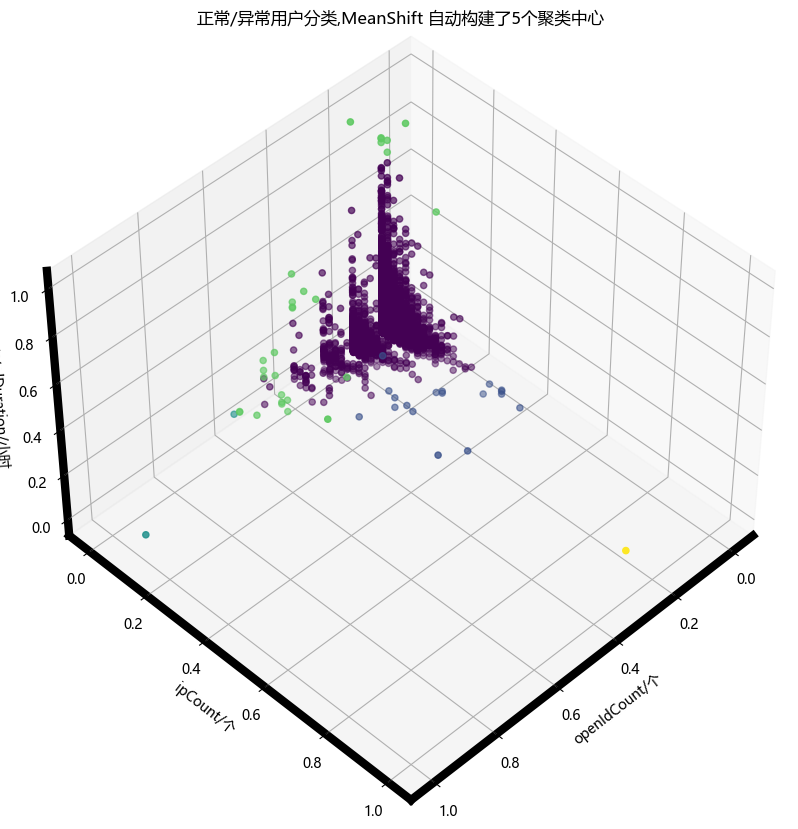

In [13]:
plt.rcParams['axes.linewidth'] = 6
fig = plt.figure(figsize=(10, 20))

ax = fig.add_subplot(projection="3d", elev=45, azim=45)

ax.set_xlabel("openIdCount/个")
ax.set_ylabel("ipCount/个")
ax.set_zlabel("totalDuration/小时")

ax.scatter(train_x[:, 0], train_x[:, 1], train_x[:, 2], c=labels)
# ax.scatter(centers[0,:], centers[1,:])

plt.title(f"正常/异常用户分类,MeanShift 自动构建了{n_clusters_}个聚类中心")

plt.savefig("./imgs/MeanShift-3-features(归一化).png")
plt.show()


In [18]:
# 将labels添加到df_final中
df_final.shape
labels.size

11211

In [20]:
df_final.assign(cluster_label=labels)

,_id,openIdCount,ipCount,totalDuration,labels,cluster_label
0,12320d4810a811ec8871b07b25146e9e,1,1,1.387451,0,0
1,cd30c9ff10c411ec8216b07b25146e9e,1,1,0.687047,0,0
2,9278d2e110c311ec8216b07b25146e9e,1,1,5.227217,0,0
3,c6abc41e10a811ec8871b07b25146e9e,1,1,0.676240,0,0
4,cc1f96a310a911ec8871b07b25146e9e,1,1,5.701767,0,0
...,...,...,...,...,...,...
11206,62bea9c266e311ecb369fa164011f743,1,3,94.286148,0,0
11207,55ca4c5910c611ec8216b07b25146e9e,1,1,3.014251,0,0
11208,6571d4d510ca11ec8216b07b25146e9e,1,1,5.725706,0,0
11209,2e77118e10ac11ec8871b07b25146e9e,1,1,1.661742,0,0


In [27]:
# 最外层[]内：行的选择条件
# 内层[]内：列的选择条件
df_final[df_final["labels"]!=0]

,_id,openIdCount,ipCount,totalDuration,labels
428,131438c610ac11ec8871b07b25146e9e,6,2,58.888726,3
573,8465706410a811ec8871b07b25146e9e,5,1,79.201898,3
1057,f847e26a10a711ec8871b07b25146e9e,2,16,47.405185,1
1265,9f982d3410c011ec8216b07b25146e9e,4,1,252.414710,3
1388,423d3e1210a911ec8871b07b25146e9e,1,21,46.183007,1
1725,b51fa1e310a911ec8871b07b25146e9e,4,1,181.792462,3
1936,a9850e0e10ab11ec8871b07b25146e9e,5,4,68.284965,3
2380,3f583f20736e11ecb369fa164011f743,6,2,57.602013,3
2393,9e925936740e11ecb369fa164011f743,3,13,34.028764,1
2787,5984d5ce10c811ec8216b07b25146e9e,2,1,476.472753,3
